# **Import Library**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

import re
import string

import spacy
from spacy.lang.id.stop_words import STOP_WORDS
nlp = spacy.blank('id')

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import csv
import requests
from io import StringIO

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Load Data**

In [3]:
df = pd.read_csv("D:/Kuliah/Semester 6/Coding Camp DBS/Capstone/SADAR/dataset/spam2.csv")

In [4]:
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [5]:
df.shape

(1143, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [7]:
df['label'] = df['label'].replace({0: 'nonspam', 1: 'spam', 2: 'spam'})
df = df.rename(columns={'Teks': 'Pesan', 'label': 'Kategori'})
df.head()

,Pesan,Kategori
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam


# **Exploratory Data Analysis**

**Perbandingan Kategori**

In [8]:
df['Kategori'].value_counts()

Kategori
spam       574
nonspam    569
Name: count, dtype: int64

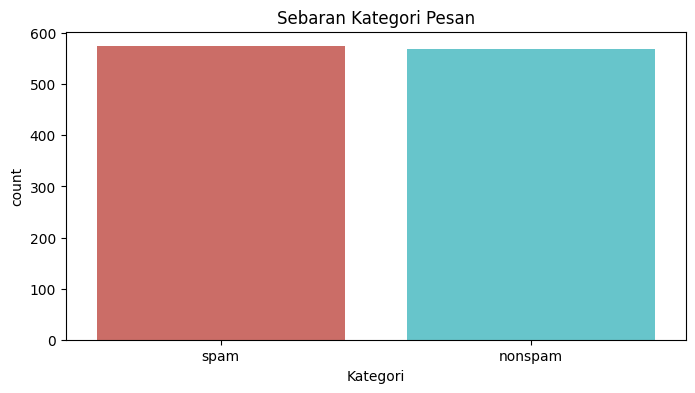

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(x = 'Kategori', data = df, hue = 'Kategori' ,palette='hls')
plt.title('Sebaran Kategori Pesan')
plt.show()

**Jumlah Karakter**

In [10]:
def count_char(sentence):
  sentence = sentence.replace(" ","")
  return len(sentence)

df['Jumlah Karakter'] = df['Pesan'].apply(count_char)

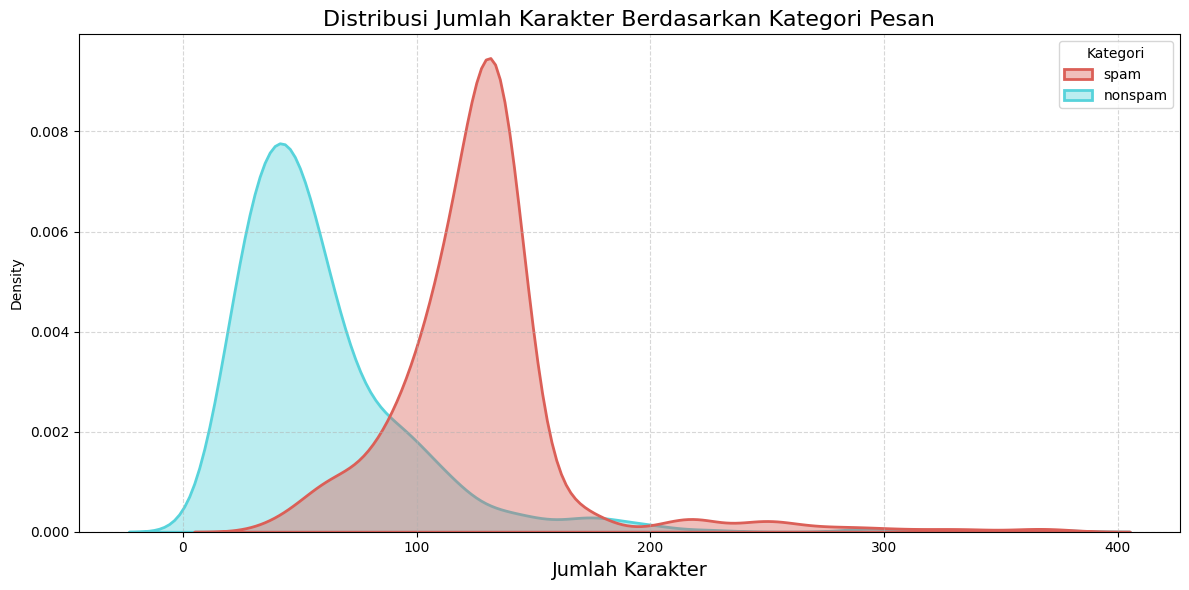

In [11]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=df, x='Jumlah Karakter', hue='Kategori', fill=True,         
            alpha=0.4, palette='hls', linewidth=2
)

plt.title('Distribusi Jumlah Karakter Berdasarkan Kategori Pesan', fontsize=16)
plt.xlabel('Jumlah Karakter', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [12]:
df['Jumlah Karakter'].describe().to_frame()

,Jumlah Karakter
count,1143.000000
mean,92.974628
std,51.178256
min,10.000000
25%,49.000000
50%,95.000000
75%,130.000000
max,373.000000


In [13]:
char_spam = df[df['Kategori'] == 'spam']['Jumlah Karakter']
char_nonspam = df[df['Kategori'] == 'nonspam']['Jumlah Karakter']

statistic, p_value = ks_2samp(char_spam, char_nonspam)

print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value}")

KS Statistic: 0.7372828423237785
P-value: 2.2631449333312155e-151


**Jumlah Huruf**

In [14]:
def count_word(sentence):
  sentence = sentence.split()
  return len(sentence)

df['Jumlah Huruf'] = df['Pesan'].apply(count_word)

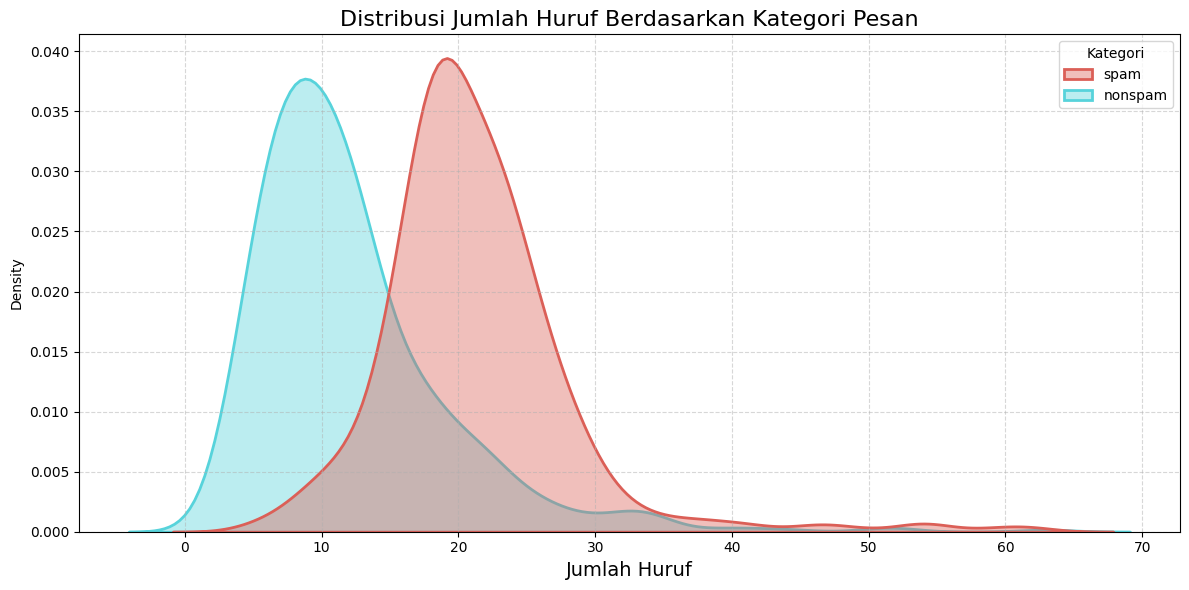

In [15]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=df, x='Jumlah Huruf', hue='Kategori', fill=True,         
            alpha=0.4, palette='hls', linewidth=2
)

plt.title('Distribusi Jumlah Huruf Berdasarkan Kategori Pesan', fontsize=16)
plt.xlabel('Jumlah Huruf', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
df['Jumlah Huruf'].describe().to_frame()

,Jumlah Huruf
count,1143.000000
mean,16.687664
std,8.439519
min,2.000000
25%,10.000000
50%,17.000000
75%,22.000000
max,63.000000


In [17]:
word_spam = df[df['Kategori'] == 'spam']['Jumlah Huruf']
word_nonspam = df[df['Kategori'] == 'nonspam']['Jumlah Huruf']

statistic, p_value = ks_2samp(word_spam, word_nonspam)

print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value}")

KS Statistic: 0.6563627122588073
P-value: 6.491246046224013e-117


In [18]:
df.head()

,Pesan,Kategori,Jumlah Karakter,Jumlah Huruf
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam,127,26
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam,128,25
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam,132,21
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam,133,21
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam,96,18


# **Text Preprocessing**

## **Cleaning**

In [19]:
df.duplicated().sum()

np.int64(1)

In [20]:
df[df.duplicated()]

,Pesan,Kategori,Jumlah Karakter,Jumlah Huruf
679,"bebas nama1, terus nanti kalau ada tgl libur, ...",nonspam,71,15


In [21]:
df = df.drop_duplicates()
df.shape

(1142, 4)

In [22]:
df.isna().sum()

Pesan              0
Kategori           0
Jumlah Karakter    0
Jumlah Huruf       0
dtype: int64

In [23]:
df = df[['Pesan', 'Kategori']]
df.head()

,Pesan,Kategori
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam


In [24]:
def cleaning(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Menghapus mentions/username
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Menghapus hashtag
    text = re.sub(r'[0-9]+', '', text) # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # Menghapus karakter non-alfanumerik
    text = re.sub(r'(\[.*?\]|\(.*?\))','', text) #  Menghapus kata-kata dalam kurung 
    text = re.sub(r'\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}\.','', text) # Menghapus format tanggal dan waktu
    text = re.sub(r'\d{2}\s\w{3,}\s\d{4}.','', text) # Menghapus format tanggal 
    text = re.sub(r'(menit|mnt|thn|tahun|minggu|mg|hari|hr|jam|jm|detik|dtk|sekon)*','', text) # Menghapus satuan waktu
    text = re.sub(r'(\d{1,}\s*gb|\d{1,}\s*kb|\d{1,}\s*mb|\d{1,}\s*tb|lte)',"", text) # Menghapus satuan byte dan kata lte
    text = re.sub(r'(ribu|rb|jt|juta|milyar|miliar|triliun|trilyun)',"", text) # Menghapus satuan uang
    text = re.sub(r'\w*\.*\w{1,}\.*\/\w{1,}','',text) # Menghapus pecahan
    text = re.sub(r'rp\s*\d{1,}\s','',text) # Menghapus jumlah tarif
    text = re.sub(r"\*\d{3,}\*\d{3,}\#","", text) # Menghapus kode aktivasi-1
    text = re.sub(r"\*\d{3,}\#","", text) # Menghapus kode aktivasi-2
    text = re.sub(r"https?://\S*|www\.\S+","", text) # Menghapus tautan
    
    text = text.replace('\n', ' ') # Mengubah baris baru menjadi spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # Menghapus tanda baca
    text = text.strip(' ') # Menghapus spasi di awal dan akhir teks
    return text

In [25]:
df_clean = df.copy()
df_clean['clean_text'] = df_clean['Pesan'].apply(cleaning)

In [26]:
df_clean.head()

,Pesan,Kategori,clean_text
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam,PROMO Beli paket Flash mulai GB di MY TELKOMSE...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam,GB hanya Rp Ribu Spesial buat Anda yang terp...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam,Plg Yth sisa kuota Flash Anda KB Download MyTe...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam,Plg Yth sisa kuota Flash Anda KB Download MyTe...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam,GB hanya Rp Ribu Spesial buat anda yang terp...


### **Case Folding**

In [27]:
def casefolding(text): 
    text = text.lower()
    return text

In [28]:
df_clean['clean_text'] = df_clean['clean_text'].apply(casefolding)

In [29]:
df_clean.head()

,Pesan,Kategori,clean_text
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam,promo beli paket flash mulai gb di my telkomse...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam,gb hanya rp ribu spesial buat anda yang terp...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam,plg yth sisa kuota flash anda kb download myte...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam,plg yth sisa kuota flash anda kb download myte...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam,gb hanya rp ribu spesial buat anda yang terp...


### **Slangwords Handling**

In [59]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "kdg": "kadang", "gmw": "gak mau", "apk": "aplikasi", "ngeleg": "lag", "bukak": "buka", "truss": "terus", "baguss": "bagus", "tpii": "tapi", "tp": "tapi", "tpi": "tapi", "bagu": "bagus", "tik tok": "tiktok", "eror": "error", "gtu": "gitu", "ngadet": "bermasalah", "gituu": "gitu", "pliss": "tolong", "pls": "tolong", "rapih": "rapi", "gambarnyaa": "gambar", "sebenernya": "sebenarnya", "kayak": "seperti", "rek": "rekening", "norek": "nomor rekening"}


def handle_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [31]:
df_clean['clean_text'] = df_clean['clean_text'].apply(handle_slangwords)

In [32]:
df_clean.head()

,Pesan,Kategori,clean_text
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam,promo beli paket flash mulai gb di my telkomse...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam,gb hanya rp ribu spesial buat anda yang terpil...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam,paling yth sisa kuota flash anda kb download m...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam,paling yth sisa kuota flash anda kb download m...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam,gb hanya rp ribu spesial buat anda yang terpil...


### **Tokenizing**

In [33]:
def tokenizing(text): 
    text = word_tokenize(text)
    return text

In [34]:
df_clean['tokenize_text'] = df_clean['clean_text'].apply(tokenizing)

In [35]:
df_clean.head()

,Pesan,Kategori,clean_text,tokenize_text
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam,promo beli paket flash mulai gb di my telkomse...,"[promo, beli, paket, flash, mulai, gb, di, my,..."
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam,gb hanya rp ribu spesial buat anda yang terpil...,"[gb, hanya, rp, ribu, spesial, buat, anda, yan..."
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam,paling yth sisa kuota flash anda kb download m...,"[paling, yth, sisa, kuota, flash, anda, kb, do..."
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam,paling yth sisa kuota flash anda kb download m...,"[paling, yth, sisa, kuota, flash, anda, kb, do..."
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam,gb hanya rp ribu spesial buat anda yang terpil...,"[gb, hanya, rp, ribu, spesial, buat, anda, yan..."


### **Stopwords Removal (Filtering)**

In [ ]:
def remove_stopwords(text):
    # Sumber Stopwords
    factory = StopWordRemoverFactory()
    sw_sastrawi = set(factory.get_stop_words())
    sw_nltk_id = set(stopwords.words('indonesian'))
    sw_nltk_en = set(stopwords.words('english'))
    sw_spacy = set(STOP_WORDS)
    
    sw_combined = sw_sastrawi.union(sw_nltk_id).union(sw_nltk_en).union(sw_spacy)

    custom_stopwords = {
        'iya','yaa','yaaa','gak','nya','na','sih','si','ku','di','ga','ya','gaa',
        'gaaa','loh','kah','woi','woii','woy','banget','yg','jg','teh','mah','da',
        'atuh','jd','km','ak','lg','ngga','nggak','tp','kalo','pake','liat','udh',
        'aja','wkwk','wkwkwk','wk','gt','gais','blm','tau','tahu','udah','utk','rb',
        'rp','dgn','ayo','isi','biar','yah','dr','bawa','gitu','eh','pas','td','sm',
        'pengen','pgn','dpt','sd','byr','min','dscn','sy','no'
    }
    
    sw_combined.update(custom_stopwords)
    
    filtered_text = []
    
    for txt in text:
        if txt not in sw_combined:
            filtered_text.append(txt)
    text = filtered_text
    return text

In [37]:
df_clean['remove_stopwords'] = df_clean['tokenize_text'].apply(remove_stopwords)

In [38]:
df_clean.head()

,Pesan,Kategori,clean_text,tokenize_text,remove_stopwords
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam,promo beli paket flash mulai gb di my telkomse...,"[promo, beli, paket, flash, mulai, gb, di, my,...","[promo, beli, paket, flash, gb, telkomsel, app..."
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam,gb hanya rp ribu spesial buat anda yang terpil...,"[gb, hanya, rp, ribu, spesial, buat, anda, yan...","[gb, ribu, spesial, terpilih, aktifkan, promo,..."
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam,paling yth sisa kuota flash anda kb download m...,"[paling, yth, sisa, kuota, flash, anda, kb, do...","[yth, sisa, kuota, flash, kb, download, mytelk..."
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam,paling yth sisa kuota flash anda kb download m...,"[paling, yth, sisa, kuota, flash, anda, kb, do...","[yth, sisa, kuota, flash, kb, download, mytelk..."
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam,gb hanya rp ribu spesial buat anda yang terpil...,"[gb, hanya, rp, ribu, spesial, buat, anda, yan...","[gb, ribu, spesial, terpilih, aktifkan, buruan..."


### **Preprocessing Result**

In [39]:
def text_result(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

In [40]:
df_clean['text_result'] = df_clean['remove_stopwords'].apply(text_result)

In [41]:
df_clean.head()

,Pesan,Kategori,clean_text,tokenize_text,remove_stopwords,text_result
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,spam,promo beli paket flash mulai gb di my telkomse...,"[promo, beli, paket, flash, mulai, gb, di, my,...","[promo, beli, paket, flash, gb, telkomsel, app...",promo beli paket flash gb telkomsel app extra ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spam,gb hanya rp ribu spesial buat anda yang terpil...,"[gb, hanya, rp, ribu, spesial, buat, anda, yan...","[gb, ribu, spesial, terpilih, aktifkan, promo,...",gb ribu spesial terpilih aktifkan promo nov bu...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",spam,paling yth sisa kuota flash anda kb download m...,"[paling, yth, sisa, kuota, flash, anda, kb, do...","[yth, sisa, kuota, flash, kb, download, mytelk...",yth sisa kuota flash kb download mytelkomsel a...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",spam,paling yth sisa kuota flash anda kb download m...,"[paling, yth, sisa, kuota, flash, anda, kb, do...","[yth, sisa, kuota, flash, kb, download, mytelk...",yth sisa kuota flash kb download mytelkomsel a...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spam,gb hanya rp ribu spesial buat anda yang terpil...,"[gb, hanya, rp, ribu, spesial, buat, anda, yan...","[gb, ribu, spesial, terpilih, aktifkan, buruan...",gb ribu spesial terpilih aktifkan buruan skb


In [42]:
print("Sebelum pre-processing: ", df_clean['Pesan'][323])
print("Sesudah pre-processing: ", df_clean['text_result'][323])

Sebelum pre-processing:  Ini Rekeningnya BANK MANDIRI. NO.Rek:150-00-1002402-2.A/n: MURTIANI
Sesudah pre-processing:  rekeningnya bank mandiri norekan murtiani


In [43]:
def plot_wordcloud_and_frequency(df, text_column, label_column, stopwords, num_word = 10):
    labels = df[label_column].unique()
    num_cols = 2

    for label in labels:
        fig, axes = plt.subplots(1, num_cols, figsize=(12, 6))

        # Filter text by label
        text = " ".join(df[df[label_column] == label][text_column])

        # Generate wordcloud with a colormap
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              stopwords=stopwords,
                              min_font_size=10,
                              colormap='viridis').generate(text)

        # Display wordcloud
        axes[0].imshow(wordcloud)
        axes[0].axis("off")
        axes[0].set_title(f'WordCloud - {label}')

        # Compute word frequency
        text_data = df[df[label_column] == label][text_column]
        word_frequency = text_data.str.split(expand=True).stack().value_counts()
        freq = word_frequency.head(num_word) # adjust numbers of word

        # Display word frequency bar plot with a color palette
        sns.barplot(x=freq.values, y=freq.index, ax=axes[1], hue = freq.values, palette="muted")
        axes[1].set_title(f'Word Frequency - {label}')
        axes[1].set_xlabel('Count')
        for p in axes[1].patches:
            axes[1].annotate("{:.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + .5), ha='left', va='center')

        plt.tight_layout()
        plt.show()

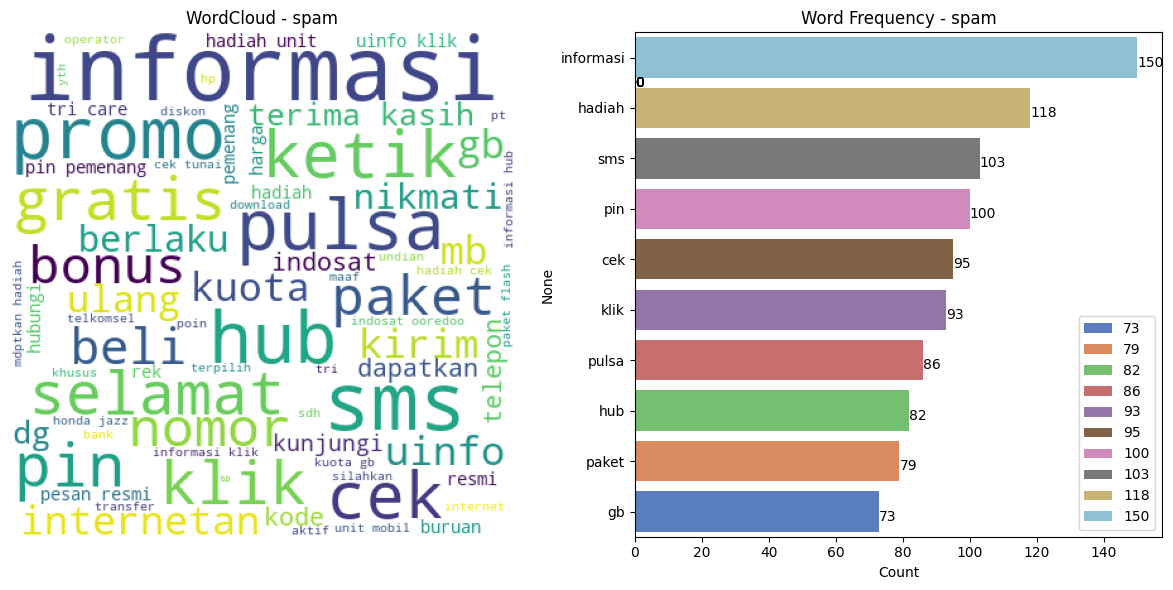

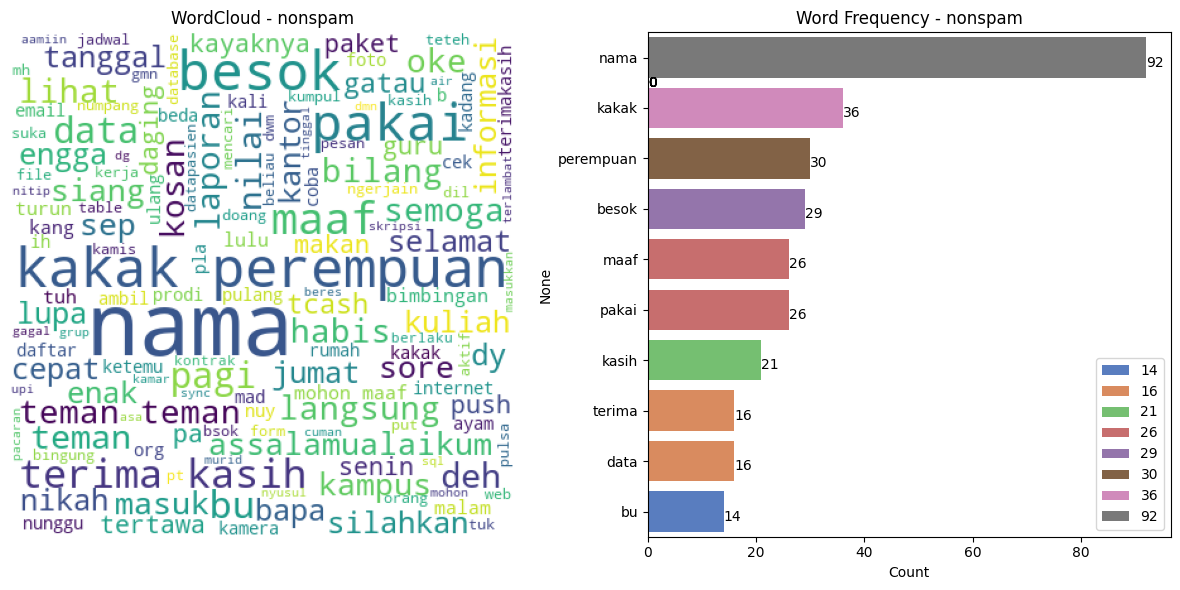

In [44]:
sw_id = set(stopwords.words('indonesian'))
plot_wordcloud_and_frequency(df_clean, 'text_result', 'Kategori', sw_id, 10)

# **Feature Extraction**

In [45]:
X = df_clean['text_result']
y = df_clean['Kategori']

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [47]:
tfidf = TfidfVectorizer(max_features=300, min_df=20, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

In [48]:
df_features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_features

,bank,beli,berlaku,besok,bonus,buruan,care,cek,dapatkan,data,...,terima,terpilih,toyota,tri,tunai,uinfo,ulang,undian,unit,yth
0,0.0,0.276014,0.0,0.0,0.0,0.323970,0.0,0.226112,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.562410,0.0,0.000000,0.0,0.0,...,0.0,0.534124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.269848,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349352
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.269848,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349352
4,0.0,0.000000,0.0,0.0,0.0,0.623546,0.0,0.000000,0.0,0.0,...,0.0,0.592185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1138,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1139,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1140,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# **Modeling**

In [49]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

In [77]:
X_train_dense = X_train1.toarray()  
X_test_dense = X_test1.toarray()  

In [78]:
model_rnn_tfidf = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax') 
])

In [79]:
model_rnn_tfidf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
history_rnn_tfidf = model_rnn_tfidf.fit(X_train_dense, y_train1, validation_data=(X_test_dense, y_test1), epochs=30, batch_size=32, callbacks=[early_stop], verbose=1)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4266 - loss: 0.6925 - val_accuracy: 0.4454 - val_loss: 0.6481
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6378 - loss: 0.5960 - val_accuracy: 0.7817 - val_loss: 0.5671
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8361 - loss: 0.5045 - val_accuracy: 0.8734 - val_loss: 0.4401
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8971 - loss: 0.3681 - val_accuracy: 0.8952 - val_loss: 0.3107
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9157 - loss: 0.2749 - val_accuracy: 0.9083 - val_loss: 0.2562
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9146 - loss: 0.2408 - val_accuracy: 0.9083 - val_loss: 0.2512
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9354 - loss: 0.2071 - val_accuracy: 0.9083 - val_loss: 0.2441
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9488 - loss: 0.1747 - val_accuracy: 0.9127 - val_loss

In [80]:
loss_rnn_tfidf, accuracy_rnn_tfidf_test = model_rnn_tfidf.evaluate(X_test_dense, y_test1)
accuracy_rnn_tfidf_train = model_rnn_tfidf.evaluate(X_train_dense, y_train1)[1]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9260 - loss: 0.1954 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9486 - loss: 0.1520


In [81]:
print(f"Train Accuracy: {accuracy_rnn_tfidf_train:.4f}")
print(f"Test Accuracy: {accuracy_rnn_tfidf_test:.4f}")

Train Accuracy: 0.9409
Test Accuracy: 0.9083


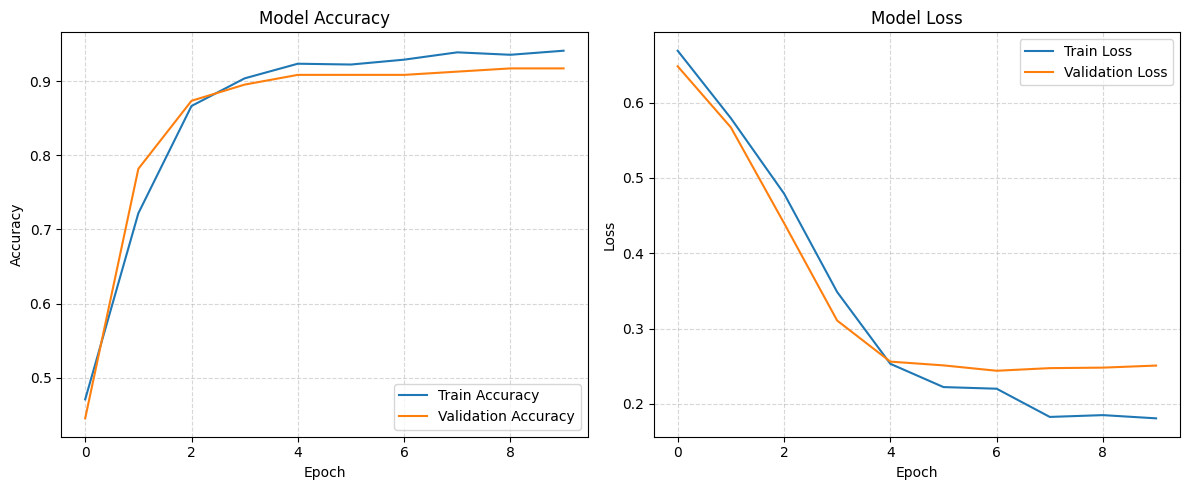

In [82]:
plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(history_rnn_tfidf.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn_tfidf.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Plot loss
plt.subplot(1,2,2)
plt.plot(history_rnn_tfidf.history['loss'], label='Train Loss')
plt.plot(history_rnn_tfidf.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# **Testing**

In [83]:
def preprocess_text(text):
    """
    Melakukan preprocessing lengkap pada teks masukan.
    """
    cleaned = cleaning(text)
    casefolded = casefolding(cleaned)
    slang_fixed = handle_slangwords(casefolded)
    tokenized = tokenizing(slang_fixed)
    filtered = remove_stopwords(tokenized)
    final_text = text_result(filtered)
    return final_text

def predict_spam(text, model, vectorizer):
    """
    Melakukan prediksi SPAM atau bukan terhadap teks masukan.

    Args:
        text (str): Teks masukan dari pengguna.
        model (keras.Model): Model klasifikasi yang telah dilatih.
        vectorizer (TfidfVectorizer): Objek TF-IDF yang telah di-fit.

    Returns:
        None. Menampilkan hasil prediksi.
    """
    preprocessed_text = preprocess_text(text)
    features = vectorizer.transform([preprocessed_text])
    prediction = model.predict(features.toarray())
    predicted_class = np.argmax(prediction, axis=1)[0]

    print(f"\nKalimat yang dimasukkan: {text}")
    if predicted_class == 1:
        print("Pesan ini adalah SPAM 🚫")
    else:
        print("Pesan ini BUKAN SPAM ✅")

In [84]:
while True:
    user_input = input("\nMasukkan kalimat (atau ketik 'exit' untuk keluar): ")
    if user_input.lower() == 'exit':
        break
    predict_spam(user_input, model_rnn_tfidf, tfidf)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Kalimat yang dimasukkan: YOI4D  Freebet 20 k Bonus Extra Deposit 25K Cashback 100% EVENT PRAGMATIC ALL 20% Event PGSOFT Terendah Deposit 10 Ribu  klik LINK https://tinyurl.com/2j328akt 
Pesan ini adalah SPAM 🚫
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Kalimat yang dimasukkan: M4'in D R@'Ja9 W'3b T3r p3r'c4'ya  lg'5g dp't i'd M'4X'W'1N d3'po 100 j'd 200 df'tr d tinydd.co/MdEbYO 
Pesan ini BUKAN SPAM ✅
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Kalimat yang dimasukkan: M4'in D R@'Ja9 W'3b T3r p3r'c4'ya  lg'5g dp't i'd M'4X'W'1N d3'po 100 j'd 200 df'tr d tinydd.co/MdEbYO 
Pesan ini BUKAN SPAM ✅
